SGD - Epoch 1 loss: 0.3157738127278041
SGD - Epoch 1 Accuracy: 96.1%
SGD - Epoch 2 loss: 0.061496894558279044
SGD - Epoch 2 Accuracy: 98.57%
SGD - Epoch 3 loss: 0.04459318905179677
SGD - Epoch 3 Accuracy: 98.66%
SGD - Epoch 4 loss: 0.03323847868632816
SGD - Epoch 4 Accuracy: 98.97%
SGD - Epoch 5 loss: 0.02859732189370485
SGD - Epoch 5 Accuracy: 98.64%
SGD - Epoch 6 loss: 0.024022163160203988
SGD - Epoch 6 Accuracy: 98.95%
SGD - Epoch 7 loss: 0.0199797774521183
SGD - Epoch 7 Accuracy: 99.05%
SGD - Epoch 8 loss: 0.016229626194428793
SGD - Epoch 8 Accuracy: 99.07%
SGD - Epoch 9 loss: 0.01481376174675356
SGD - Epoch 9 Accuracy: 98.79%
SGD - Epoch 10 loss: 0.012879956475747006
SGD - Epoch 10 Accuracy: 98.99%
AdaDelta - Epoch 1 loss: 0.008542765703397525
AdaDelta - Epoch 1 Accuracy: 98.99%
AdaDelta - Epoch 2 loss: 0.00854048339714549
AdaDelta - Epoch 2 Accuracy: 98.99%
AdaDelta - Epoch 3 loss: 0.00854417201951671
AdaDelta - Epoch 3 Accuracy: 98.99%
AdaDelta - Epoch 4 loss: 0.0085356405227710

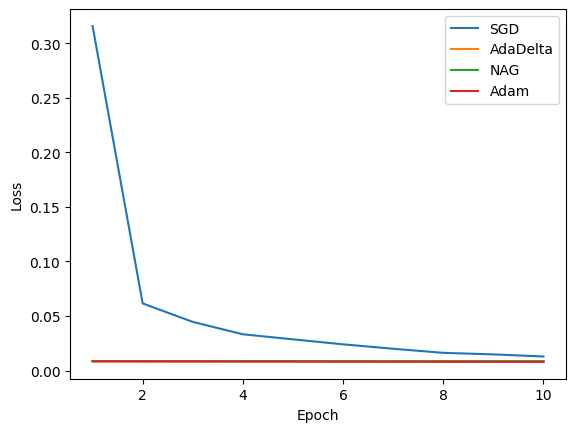

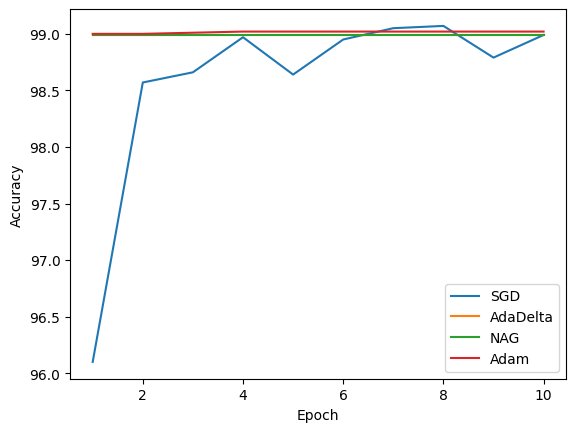

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as fctl
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = fctl.relu(self.conv1(x))
        x = fctl.max_pool2d(x, 2)
        x = fctl.relu(self.conv2(x))
        x = fctl.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = fctl.relu(self.fc1(x))
        x = fctl.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet()

criterion = nn.CrossEntropyLoss()

optimizer_sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer_adadelta = optim.Adadelta(model.parameters(), lr=0.001)
optimizer_nag = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

def train_test_model(optimizer, name):
    model.train()
    losses = []
    accuracy = []
    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(trainloader)
        losses.append(epoch_loss)
        print(f"{name} - Epoch {epoch + 1} loss: {epoch_loss}")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        epoch_accuracy = 100 * correct / total
        print(f"{name} - Epoch {epoch + 1} Accuracy: {epoch_accuracy}%")
        accuracy.append(epoch_accuracy)
        model.train()

    return losses, accuracy

sgd_losses, sgd_accuracy = train_test_model(optimizer_sgd, "SGD")
adadelta_losses, adadelta_accuracy = train_test_model(optimizer_adadelta, "AdaDelta")
nag_losses, nag_accuracy = train_test_model(optimizer_nag, "NAG")
adam_losses, adam_accuracy = train_test_model(optimizer_adam, "Adam")

epochs = range(1, 11)
plt.plot(epochs, sgd_losses, label='SGD')
plt.plot(epochs, adadelta_losses, label='AdaDelta')
plt.plot(epochs, nag_losses, label='NAG')
plt.plot(epochs, adam_losses, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(epochs, sgd_accuracy, label='SGD')
plt.plot(epochs, adadelta_accuracy, label='AdaDelta')
plt.plot(epochs, nag_accuracy, label='NAG')
plt.plot(epochs, adam_accuracy, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()